In [1]:
#Google Drive'a erişim sağlanır. # En başta çalıştırılan kod ile aynı işlevi yapar.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Drive içesinde yer alan veri seti içerine gidilmiştir. Artık bağlantı ve path ayarları yapıldığına göre kütüphanelere ekleyerek modelimizi oluşturmaya
#başlayabiliriz.
%cd /content/drive/My Drive/Veriseti

/content/drive/My Drive/Veriseti


In [3]:
#Buradaki kod satırlar ile de GPU ortamında olup olmadığımızı kontrol edebiliriz.
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
#Gerekli kütüphaleri ekleme işlemleri. 
from keras.models import Sequential 
from keras.layers import Conv2D , Activation ,MaxPooling2D ,MaxPool2D, Flatten , Dropout , Dense  # Con. , pooling , fully con. katmanları ve parametleri 
from keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array , image #İmagelar için veri sentezi yapar iken kullanılır.
from keras.layers.normalization import BatchNormalization # Normalizasyon katmanı eklemek için kullanılır. 
from glob import glob
import numpy as np 
import matplotlib.pyplot as plt  
from keras.optimizers import RMSprop,SGD,Adam # Optimizasyon algoritmaları için gerekli kütüphanelerdir
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator 
import os

In [5]:
#Veri Seti Parçalanması , Sentezi ve Normalizasyonu:

train_path= "/content/drive/My Drive/Veriseti/train/"  #Burada verileri yalnızca train ve test olarak iki gruba ayırdık.Elimizde zaten yetersiz veri olduğu için
test_path = "/content/drive/My Drive/Veriseti/validation/"  #validation seti olarak ayrı bir veri seti oluşturulmadı. Test seti , valid. seti olarak kullanıldı.

batch_size=1 #Veri kümesinin boyutu oldukça küçük olduğunda batch_size=1 yapılarak , S.Gradient Descent yapılmıştır. 80 adet traning seti
#olduğu için her epochta 80 adet iteasyon olur. Her iterasyon sonunda weightlar güncellenir.
#Datasetin boyutu artıkça da batch_size boyutu arttırılmalıdır.

train_datagen = ImageDataGenerator(rescale = 1./255, # Burada 0-255 grayscale daki imagelar 0-1 arasına getirilerek binary normalization yapılır.
                                  #Yüksek piksek aralıkları daha güçlü loss,düşük piksekler daha zayıf loss oluşturur. Bunun önüne geçmek için norm. yapılır.
                                   rotation_range=30, #Aynı zamanda sağa-sola kaydırma , zoom yapma , rotasyon değiştirme , yatay- dikey çevirme gibi 
                                   width_shift_range=0.2, #methodlar ilede elimizdeki veri setleri üzerinden yeni veriler üretirilir(DATAAUGMENTATİON)
                                   height_shift_range=0.2) 

test_datagen = ImageDataGenerator(rescale = 1./255) # Train setini normalize ettiğimiz için , test setinide normalize ettik.

train_generator = train_datagen.flow_from_directory(train_path , #Eğitim verilerimizin olduğu dizin ve bu dizinde train_datagen'a tanımlanan işlemler gerçekleşecektir.
                                     target_size=(224,224), #İmage size
                                     color_mode='grayscale',
                                     batch_size=batch_size,  #batch_size boyutu kadar conv.modeline giriş yapar.
                                     class_mode = 'categorical', #Categorical sınıf kullanıldı.2'li sınıflandırıcılar için binary tercih edilmesine rağmen bu modelde iyi işlev vermedi.
                                     shuffle=True) #Verileri alfabetik sıra ile değil karmaşık bir şekilde yollar.
                                                  
test_generator = test_datagen.flow_from_directory(test_path,
                                         target_size=(224,224),
                                         color_mode='grayscale',
                                         batch_size=batch_size,
                                         class_mode = 'categorical',
                                         shuffle = False)


Found 80 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [7]:
#CNN MİMARİSİ 

model = Sequential()
model.add(Conv2D(filters=16,kernel_size=(5,5),input_shape=(224,224,1))) #İnput üzerinde 3*3 lük filtreler gezdirilerek özellikler çıkartılır.Derinliği 32 olucak bir çıktı verir.
model.add(Activation('relu')) # Nöronlardan gelen w[n]*input[n] değerleri ;0'dan küçük ise 0 olarak,büyük ise olduğu gibi geçer.Sinir Ağları yakın bir yapısı bulunur.
model.add(MaxPooling2D(pool_size=(2,2)))#Kısaca nöronların verdiği kararlardan en donimant olanı seçerek gereksiz verileri azaltır.
#2*2 lik alanlardaki max değer alınarak yeni bir çıktı elde edilir. Parametre aynı kalır, parametre öğrenmesine gerek kalmadan işlenecek veri azalır.

model.add(Conv2D(filters=32,kernel_size=(3,3)))
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(filters=64,kernel_size=(3,3)))
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2))) 


model.add(Flatten()) # Tam bağlı katmana input olarak verebilmek için düzleştirme / vektör haline getirme işlemi yapılır.
model.add(Dense(256)) # Tam bağlı katmandır. 128 nörondan oluşur. 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25)) #Random bir şekilde farklı nöronları inaktif ederek overfitting(aşırı ezberleme) önlenmesi için bir düzenleme methodu.
model.add(Dense(2)) # İki adet  sınıfım olduğu için (benign and malign) dense=2 seçilmiştir.
model.add(Activation('softmax')) # Kategorik sınıfladırıcı için softmax , binary sınıflandırıcı için sigmoid tercih edilir.

print(model.summary()) #Mimari hakkında (boyut, parametre , vs.) adım adım bilgi verir.

optimizer = Adam(learning_rate=0.0001) # Adam optimizasyonu ve Lr=0.0001 de model daha iyi performans sergiledi.
model.compile(loss = 'categorical_crossentropy' , optimizer= optimizer, metrics=['accuracy'])
#Loss fonksiyonu olarak categorical kullanılmıştır. Literatür taraması yapıldığında binary ile tiroid nodül snıflandırılması daha başarılı olmasına rağmen bu modelde işlev vermemiştir.
#Loss fonk. ile [model tahmini - gerçek değer] arası fark hata oranı olarak gönderilir.
#Bu hata değerini azaltmak adına belirli bir lr ile hatanın 0' yakın olduğu (tam sıfır istenmez = aşırıöğrenme olur) değere olduğu optimizasyon gerçekleşir.
#Optimizasyon ile weight , bias değerleri güncellenir.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 220, 220, 16)      416       
_________________________________________________________________
activation_6 (Activation)    (None, 220, 220, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 108, 108, 32)      4640      
_________________________________________________________________
activation_7 (Activation)    (None, 108, 108, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)       

In [8]:
#Compile (Modeli Eğitime Verme):

checkpoint = ModelCheckpoint('thyroidnodules.h5',monitor='val_accuracy',mode='max', verbose=1, save_best_only=True)
callbacks =[checkpoint] #Val. accuracy arttıkça ilgili model dosyasını günceller.

hist = model.fit_generator(generator=train_generator , steps_per_epoch= 80//batch_size, epochs=100 ,
                           callbacks=callbacks, validation_data=test_generator ,validation_steps=21//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
80/80 [==============================] - 86s 490ms/step - loss: 0.6930 - accuracy: 0.5919 - val_loss: 0.6963 - val_accuracy: 0.3810

Epoch 00001: val_accuracy improved from -inf to 0.38095, saving model to thyroidnodules.h5
Epoch 2/100
80/80 [==============================] - 1s 9ms/step - loss: 0.6920 - accuracy: 0.6904 - val_loss: 0.6934 - val_accuracy: 0.3810

Epoch 00002: val_accuracy did not improve from 0.38095
Epoch 3/100
80/80 [==============================] - 1s 9ms/step - loss: 0.6909 - accuracy: 0.6951 - val_loss: 0.6909 - val_accuracy: 0.6190

Epoch 00003: val_accuracy improved from 0.38095 to 0.61905, saving model to thyroidnodules.h5
Epoch 4/100
80/80 [==============================] - 1s 9ms/step - loss: 0.6908 - accuracy: 0.6501 - val_loss: 0.6891 - val_accuracy: 0.5714

Epoch 00004: val_accuracy did not improve from 0.61905
Epoch 5/100
80/80 [==============================] - 1s 9ms/step - loss: 0.6912 - accuracy: 0.5896 - val_loss: 0.6870 - val_accuracy: 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[ 3  4]
 [ 2 13]]
Classification Report
              precision    recall  f1-score   support

      benign       0.60      0.43      0.50         7
      malign       0.76      0.87      0.81        15

    accuracy                           0.73        22
   macro avg       0.68      0.65      0.66        22
weighted avg       0.71      0.73      0.71        22



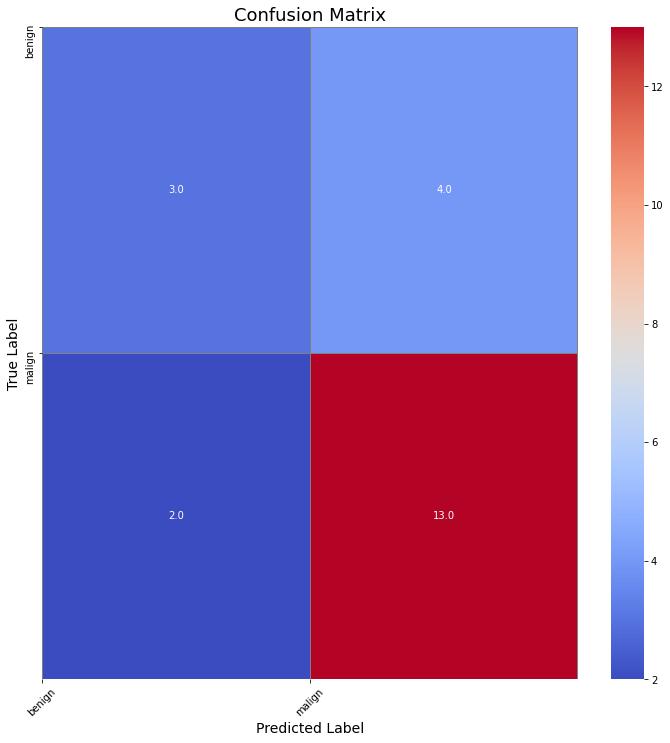

In [14]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, 21// batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
confusion_mtx = confusion_matrix(test_generator.classes, y_pred) 

print('Classification Report')
target_names =['benign','malign']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

names=['benign','malign']
f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap='coolwarm',linecolor="gray", fmt= '.1f',ax=ax)
tick_marks = np.arange(len(names))
plt.xticks(tick_marks, names, rotation=45)
plt.yticks(tick_marks, names)
plt.xlabel("Predicted Label",fontsize=14)
plt.ylabel("True Label",fontsize=14)
plt.title("Confusion Matrix",fontsize=18)
plt.show()

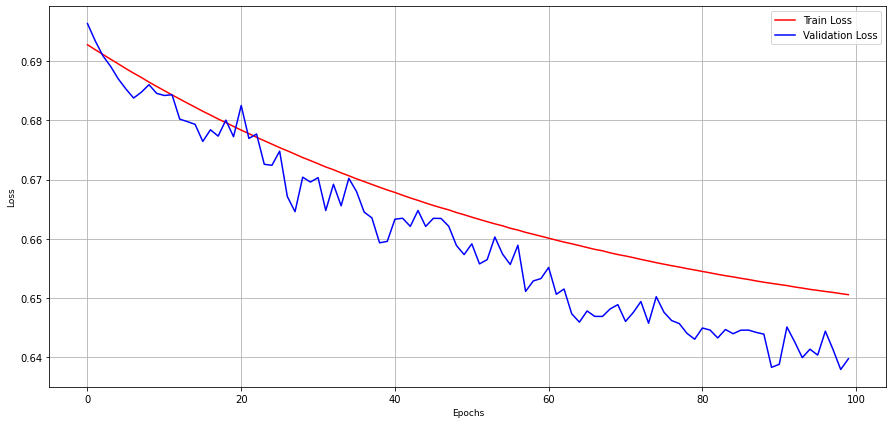

In [19]:
plt.figure(figsize=(15,7))
#plt.suptitle('TRAİNİNG RESULT',fontsize=22)
plt.ylabel('Loss',fontsize=9)
plt.xlabel("Epochs", fontsize = 9)
plt.plot(hist.history['loss'], color='r',label='Train Loss')
plt.plot(hist.history['val_loss'], color='b',label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')


